In [197]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [198]:
df = pd.read_csv('ecom_processed.csv', sep=',', decimal=".")
df.head()

,Unnamed: 0,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,payer,time_of_day,final_price
0,0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,1,ночь,9999.0
1,1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,0,утро,NaN
2,2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,0,ночь,NaN
3,3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,0,вечер,NaN
4,4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,0,день,NaN


### Гипотеза 5: средний чек отличается в зависимости от времени суток

In [199]:
time_of_day = ['ночь', 'утро', 'день', 'вечер']
data_time_of_day = {}
for time in time_of_day:
    final_price = df.loc[(df["time_of_day"] == time) & (df["payer"] == 1)]["final_price"]
    data_time_of_day[time] = final_price
    print(f"{time.capitalize()}: {round(final_price.mean(), 2)}")

Ночь: 5496.96
Утро: 5117.75
День: 5441.47
Вечер: 5497.21


Исходя из средних значений, есть увеличение среднего чека вечером и ночью.

(array([35.,  6., 10.,  0.,  0.,  0.,  0.,  0.,  2.,  3.]),
 array([4499., 5049., 5599., 6149., 6699., 7249., 7799., 8349., 8899.,
        9449., 9999.]),
 <BarContainer object of 10 artists>)

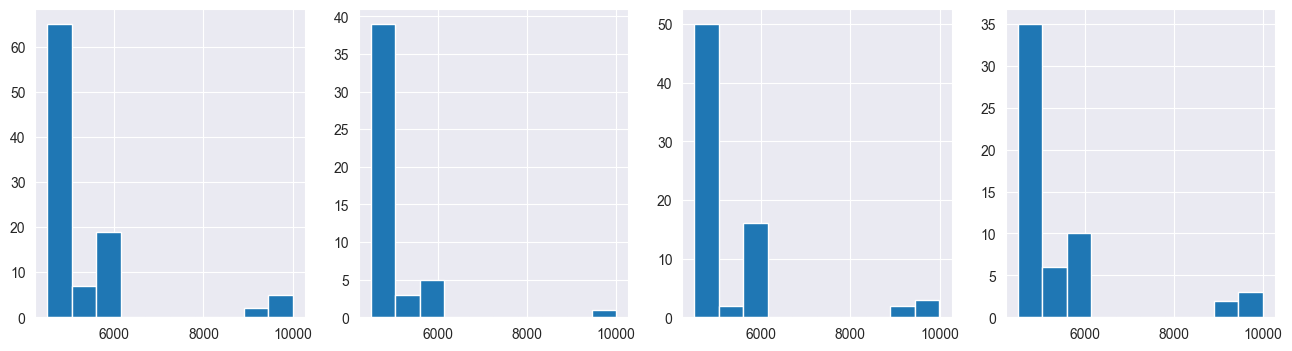

In [200]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.hist(data_time_of_day[time_of_day[0]])
ax2.hist(data_time_of_day[time_of_day[1]])
ax3.hist(data_time_of_day[time_of_day[2]])
ax4.hist(data_time_of_day[time_of_day[3]])

Так как распределение ненормальное, применяем критерий Краскела

In [201]:
round(stats.kruskal(*data_time_of_day)[1], 2)

0.39

P-value больше 0.05, статистически значимого результата нет

### Гипотеза 6: есть взаимосвязь между продолжительностью сессии с суммой покупок

In [202]:
data_only_purchases = df.dropna()
if stats.shapiro(data_only_purchases["final_price"])[1] >= 0.05 and stats.shapiro(data_only_purchases["sessiondurationsec"])[1] >= 0.05:
    print("Распределение нормальное, используем метод Пирсона")
    pval = stats.pearsonr(data_only_purchases["final_price"], data_only_purchases["sessiondurationsec"])
else:
    print("Распределение ненормальное, используем метод Спирмена")
    pval = stats.spearmanr(data_only_purchases["final_price"], data_only_purchases["sessiondurationsec"])
print(pval[1])

Распределение ненормальное, используем метод Спирмена
0.64807754918915


P-value больше 0.05, статистически значимого результата нет

### Гипотеза 7: есть взаимосвязь продолжительности сеанса и типа устройства

In [203]:
devices = df["device"].unique()
data_devices = {}
for device in devices:
    session = df.loc[df["device"] == device, "sessiondurationsec"]
    data_devices[device] = session
    print(f"{device.capitalize()}: {round(session.mean(), 2)}")

Iphone: 1625.27
Pc: 1806.77
Mac: 1652.73
Android: 1801.14


In [204]:
for device in devices:
    if stats.shapiro(data_devices[device])[1] >= 0.05:
        print(f"Распределение в группе {device} нормальное")

Во всех группах распределение ненормальное, используем метод Краскела

In [205]:
round(stats.kruskal(*data_devices)[1], 2)

0.39

P-value больше 0.05, статистически значимой корреляции не обнаружено

### Гипотеза 8: есть взаимосвязь продолжительности сеанса и типа рекламного канала

In [206]:
channels = df["channel"].unique()
data_channels = {}
for channel in channels:
    session = df.loc[df["channel"] == channel, "sessiondurationsec"]
    data_channels[channel] = session
    print(f"{channel.capitalize()}: {round(session.mean(), 2)}")

Социальные сети: 1602.86
Organic: 1746.98
Реклама у блогеров: 1669.64
Контекстная реклама: 1871.79
Email-рассылки: 1919.26


In [207]:
for channel in channels:
    if stats.shapiro(data_channels[channel])[1] >= 0.05:
        print(f"Распределение в группе {channel} нормальное")

Во всех группах распределение ненормальное, используем метод Краскела

In [208]:
round(stats.kruskal(*data_channels)[1], 2)

0.41

P-value больше 0.05, статистически значимой корреляции не обнаружено